## Description
This notebook processes all datasets containing German keywords (dataset_keyword_DE). Common or generic keywords are filtered out, and an LDA model from the Gensim library is trained on the remaining keywords. The model extracts topics and assigns them to each dataset entry. Each entry receives a probability distribution indicating its degree of association with each topic.

The code was developed with support from ChatGPT-4.

In [7]:
import re
import numpy as np
import pandas as pd
from gensim import corpora, matutils
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from nltk.corpus import stopwords
from nltk import download
import ast
import matplotlib.pyplot as plt
from collections import Counter

# Download German stopwords (only required once)
download('stopwords')
german_stopwords = set(stopwords.words('german'))

# Load the dataset
inputdata_file = 'data/merged_dataset_metadata_labelled.csv'
df = pd.read_csv(inputdata_file, low_memory=False)

# Filter: only rows labeled 'T' and with iteration_index == 1
df = df[(df['mobilitydata_labelled'] == 'T') & (df['iteration_index'].isin([1]))]

# Keep only rows with non-empty 'dataset_keyword_DE'
df = df[df['dataset_keyword_DE'].notnull() & df['dataset_keyword_DE'].str.strip().ne("")]

# Keywords to be removed
keywords_to_remove = [
    'verkehr',
    'opendata', 
    'geoportal', 
    'opendata.swiss', 
    'bgdi bundesgeodaten-infrastruktur', 
    'bgdi-bundesgeodaten-infrastruktur', 
    'geodaten',
    'geobasisdaten',
    'geodatenmodell'
]

# Convert string representations to lists (if needed)
df['dataset_keyword_DE'] = df['dataset_keyword_DE'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Remove unwanted keywords
def remove_unwanted_keywords(keyword_list):
    if isinstance(keyword_list, list):
        return [kw for kw in keyword_list if kw.lower() not in keywords_to_remove]
    return keyword_list

df['dataset_keyword_DE'] = df['dataset_keyword_DE'].apply(remove_unwanted_keywords)

# Tokenization with stopword filtering
def tokenize_keywords(keyword_list):
    tokens = []
    for item in keyword_list:
        tokens.extend(re.findall(r'\b\w+\b', item.lower()))
    return [token for token in tokens if token not in german_stopwords and len(token) > 2]

texts = df['dataset_keyword_DE'].apply(tokenize_keywords).tolist()

print(f"{len(df)} cleaned and tokenized entries with label 'T' found.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\haabs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3132 cleaned and tokenized entries with label 'T' found.


In [8]:
# Create dictionary and corpus from tokenized texts
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=100, alpha='auto', passes=50, random_state=1)

# Visualize the topics using pyLDAvis
vis_data = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)


In [9]:
# Generate full topic distributions per document
document_topic_distributions = [lda_model.get_document_topics(doc, minimum_probability=0.0) for doc in corpus]

# Sort topics by descending probability
document_topic_distributions = [sorted(doc_topics, key=lambda x: x[1], reverse=True) for doc_topics in document_topic_distributions]

# Store the topic distributions in the DataFrame
df['topic_distribution'] = document_topic_distributions

# Identify the most probable topic for each document
df['assigned_topic'] = df['topic_distribution'].apply(lambda dist: dist[0][0] if dist else -1)

# Optional: show example output
print("Example: topic distribution and top topic for the first document:")
print("Distribution:", df['topic_distribution'].iloc[0])
print("Top topic:", df['assigned_topic'].iloc[0])

Example: topic distribution and top topic for the first document:
Distribution: [(79, 0.020949703), (38, 0.01635968), (55, 0.015154479), (76, 0.014243524), (99, 0.014020678), (57, 0.013616054), (1, 0.012975208), (59, 0.012505228), (96, 0.012464901), (12, 0.012044988), (78, 0.011893434), (67, 0.011802275), (46, 0.01179397), (49, 0.011763946), (48, 0.011578656), (51, 0.011505719), (40, 0.011368696), (33, 0.011294859), (66, 0.011147631), (30, 0.011141313), (13, 0.011100094), (17, 0.011078324), (58, 0.011062114), (62, 0.01098081), (18, 0.010951101), (25, 0.010943375), (35, 0.010906588), (11, 0.010818014), (63, 0.010765264), (9, 0.0107198795), (80, 0.010551427), (41, 0.010269603), (93, 0.010234094), (90, 0.010108815), (91, 0.009983052), (73, 0.00998287), (21, 0.009941662), (50, 0.009940191), (86, 0.009938265), (83, 0.009909672), (27, 0.009855321), (54, 0.0096935835), (77, 0.00961786), (19, 0.009593477), (72, 0.009589541), (15, 0.00957844), (0, 0.00955063), (56, 0.0095149465), (87, 0.0094747

In [13]:
# File paths
model_path = "data/lda_model.gensim"
dict_path = "data/lda_dictionary.dict"
file_path = "data/02_LDA_cluster.csv"

# Save model, dictionary, and DataFrame to CSV
lda_model.save(model_path)
dictionary.save(dict_path)
df.to_csv(file_path, index=False)

print(f"LDA model saved to: {model_path}")
print(f"Dictionary saved to: {dict_path}")
print(f"CSV with topic distributions and assigned topic IDs saved to: {file_path}")

LDA model saved to: data/lda_model.gensim
Dictionary saved to: data/lda_dictionary.dict
CSV with topic distributions and assigned topic IDs saved to: data/02_LDA_cluster.csv


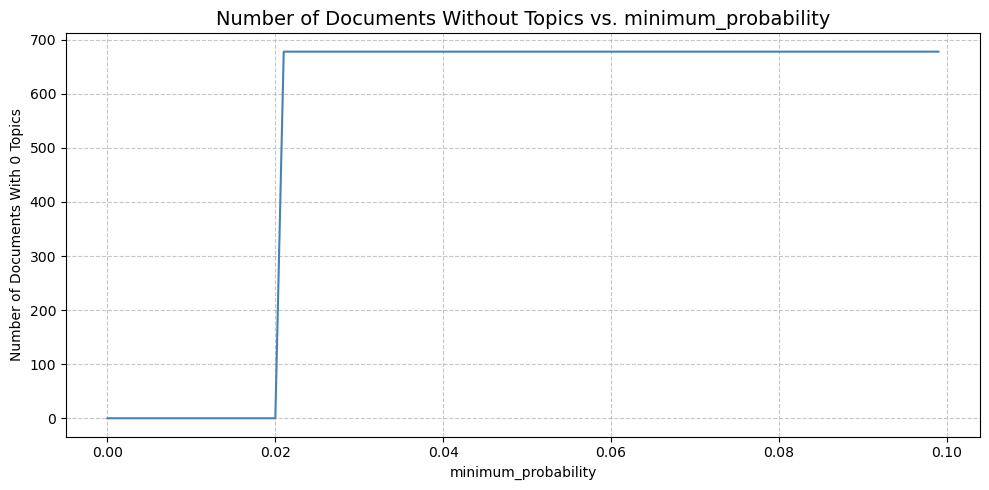

In [11]:
# Range of values for minimum_probability
thresholds = np.arange(0.0, 0.1, 0.001)
zero_topic_counts = []

# Count how many documents receive 0 topics for each threshold
for threshold in thresholds:
    count_zero = 0
    for doc in corpus:
        topics = lda_model.get_document_topics(doc, minimum_probability=threshold)
        if len(topics) == 0:
            count_zero += 1
    zero_topic_counts.append(count_zero)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(thresholds, zero_topic_counts, color='steelblue')
plt.title("Number of Documents Without Topics vs. minimum_probability", fontsize=14)
plt.xlabel("minimum_probability")
plt.ylabel("Number of Documents With 0 Topics")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

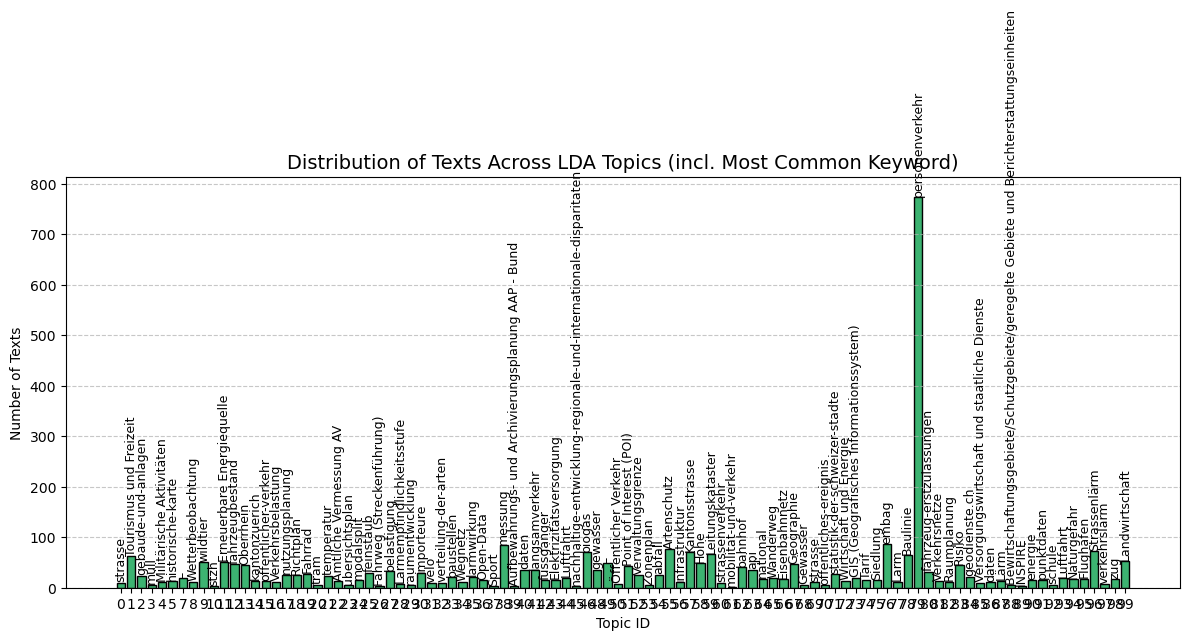

In [12]:
# Extract the most probable topic for each document
main_topics = [max(lda_model.get_document_topics(doc), key=lambda x: x[1])[0] for doc in corpus]

# Add the assigned topic as a new column in the DataFrame
df['assigned_topic'] = main_topics

# If necessary: convert string representations of lists to actual lists
df['dataset_keyword_DE'] = df['dataset_keyword_DE'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# Determine the most frequent keyword per topic
topic_top_words = {}
for topic_id in sorted(df['assigned_topic'].unique()):
    topic_tokens = df[df['assigned_topic'] == topic_id]['dataset_keyword_DE'].explode()
    if not topic_tokens.empty:
        word_counts = Counter(topic_tokens)
        most_common_word, _ = word_counts.most_common(1)[0]
        topic_top_words[topic_id] = most_common_word
    else:
        topic_top_words[topic_id] = "–"

# Count the number of documents assigned to each topic
topic_counts = df['assigned_topic'].value_counts().sort_index()
df_stats = topic_counts.reset_index()
df_stats.columns = ['Topic', 'Number_of_Texts']

# Create a bar chart of topic distribution
plt.figure(figsize=(12, 6))
bars = plt.bar(df_stats['Topic'].astype(str), df_stats['Number_of_Texts'], color='mediumseagreen', edgecolor='black')
plt.title("Distribution of Texts Across LDA Topics (incl. Most Common Keyword)", fontsize=14)
plt.xlabel("Topic ID")
plt.ylabel("Number of Texts")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with most frequent keyword (rotated)
for bar in bars:
    height = bar.get_height()
    topic_id = int(bar.get_x() + 0.5)
    word = topic_top_words.get(topic_id, "–")
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1.0,
        f'{word}',
        ha='center',
        va='bottom',
        fontsize=9,
        rotation=90
    )

plt.tight_layout()
plt.show()